# Feature Extraction Test Data

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
%matplotlib inline

In [3]:
os.getcwd()

'/Users/tilia/HZ/SmartCleanCityHackZurich19'

In [4]:
%cd data

/Users/tilia/HZ/SmartCleanCityHackZurich19/data


## Load the Files

In [13]:
pred_msr = pd.read_csv("./2019-09-27-basel-measures-prediction-cleaned.csv", sep=";") 

In [14]:
print(pred_msr.shape)
pred_msr.head()

(7292, 3)


,osm_id,cci_id,date
0,172611027,86_12812,2019-06-25 6:25:49
1,3828924874,260,2019-06-25 6:26:22
2,23913163,86_9255,2019-06-25 6:26:26
3,23913163,86_17476,2019-06-25 6:26:26
4,144481239,86_12223,2019-06-25 6:27:21


In [15]:
pred_msr_features = pred_msr.copy()

## Add features from datetime: hour, day, weekday, month and year

In [17]:
import datetime

def get_datefeat(date_str):
    a = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    weekday = a.weekday()
    month = a.month
    day = a.day
    hour = a.hour
    year = a.year
    
    return (hour, day, weekday, month, year)

datefeat = pd.DataFrame.from_records(pred_msr_features.date.apply(lambda x: get_datefeat(x)).tolist(), columns=['hour', 'day', 'weekday', 'month', 'year'])

pred_msr_features = pred_msr_features.join(datefeat)

pred_msr_features.head()

,osm_id,cci_id,date,hour,day,weekday,month,year
0,172611027,86_12812,2019-06-25 6:25:49,6,25,1,6,2019
1,3828924874,260,2019-06-25 6:26:22,6,25,1,6,2019
2,23913163,86_9255,2019-06-25 6:26:26,6,25,1,6,2019
3,23913163,86_17476,2019-06-25 6:26:26,6,25,1,6,2019
4,144481239,86_12223,2019-06-25 6:27:21,6,25,1,6,2019


### Plot hours when rubbish situation was recorded

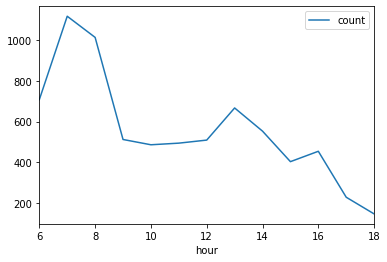

In [18]:
b = pd.DataFrame(pred_msr_features.hour.value_counts()).reset_index().sort_values(by='index')

b.columns = ['hour', 'count']

b.plot(x='hour', y='count')

## Possible feature for future websearches (currently not used: German names for months and weekdays)

In [19]:
german_months = {1:'Januar', 2:'Februar', 3:'März', 4:'April', 5:'Mai', 6:'Juni', 7:'Juli', 8:'August', 9:'September',
                10:'Oktober', 11:'November', 12:'Dezember'}

german_weekdays = {0:'Montag', 1:'Dienstag', 2:'Mittwoch',3:'Donnerstag',4:'Freitag', 5:'Samstag', 6:'Sonntag'}


pred_msr_features['month_german'] = pred_msr_features.month.apply(lambda x: german_months[x])
pred_msr_features['weekday_german'] = pred_msr_features.weekday.apply(lambda x: german_weekdays[x])



## Encode hours as daytimes: night, morning, afternoon, evening

In [20]:
def get_daytime(hour):
    if 0 <= hour < 6:
        return 'night'
    if 6 <= hour < 12:
        return 'morning'
    if 12 <= hour < 19:
        return 'afternoon'
    if 19 <= hour < 24:
        return 'evening'

pred_msr_features['daytime'] = pred_msr_features.hour.apply(lambda x: get_daytime(x))

## Add list of dates (n dates before the current date) as relevant time frame for social media (twitter)

In [21]:
def get_daydate(date_str):
    '''Returns shortened date string in the format %Y-%m-%d.'''
    
    d = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
       
    return str(datetime.datetime.strftime(d, '%Y-%m-%d'))

pred_msr_features['day_date'] = pred_msr_features.date.apply(lambda x: get_daydate(x))

pred_day_tw_feat = pred_msr_features[['day_date']].copy().drop_duplicates()

In [22]:
def get_reldates(day_date_str, num_days_before):
    '''Get datestrings for the given number of days before the current day. Includes the current day.'''
    
    d = datetime.datetime.strptime(day_date_str, '%Y-%m-%d')
    
    dates = [d - datetime.timedelta(days=i) for i in range(num_days_before+1)]
    
    return [str(datetime.datetime.strftime(d, '%Y-%m-%d')) for d in dates]

pred_day_tw_feat['twitter_reldates'] = pred_day_tw_feat.day_date.apply(lambda x: ', '.join(get_reldates(x, 2)))

In [23]:
pred_day_tw_feat.head()

,day_date,twitter_reldates
0,2019-06-25,"2019-06-25, 2019-06-24, 2019-06-23"
440,2019-06-26,"2019-06-26, 2019-06-25, 2019-06-24"
1023,2019-06-27,"2019-06-27, 2019-06-26, 2019-06-25"
1460,2019-06-28,"2019-06-28, 2019-06-27, 2019-06-26"
2105,2019-08-28,"2019-08-28, 2019-08-27, 2019-08-26"


## Load relevant twitter data

In [24]:
tw_df = pd.read_csv('twitter_data/all_tweets_relcols.csv')

In [25]:
tw_df.head()

,id,author,re_tweeter,text,hashtags,mentions,favorite_count,day_date
0,1001074611705057280,baselcommunity,NaN,I Basel!pic.twitter.com/spqBrYkXky,[],[],48,2018-05-28
1,1177675468780130304,baselcommunity,NaN,Sister Duo Deer Park Avenue Premiere Empowerin...,[],['@the'],1,2019-09-27
2,1175859833960050688,deerparkavenue,baselcommunity,Love these Sunday sessions! What’s your favour...,[],[],21,2019-09-22
3,1175359315785502721,drBachme,baselcommunity,"Ein #Dauerbrenner im #Strassenverkehr, auch in...","['#Dauerbrenner', '#Strassenverkehr', '#Basel'...",[],4,2019-09-21
4,1175073074510749697,FC_Basel_en,baselcommunity,| Our Round of 16 game in the @SchweizerCup ag...,"['#FCBasel1893', '#FCSLOFCB']","['@SchweizerCup', '@FCSLO1']",2,2019-09-20


## Match tweets to relevant dates

In [26]:
class RelevantDateTweetsFeats(object):
    def __init__(self, twitter_df):
        self.data = dict()
        self.twitter = twitter_df
        
    def get_day_tweets(self, day_date):
        if day_date in self.data:
            return self.data[day_date]
        else:
            rel_df = self.twitter[self.twitter['day_date'] == str(day_date)].copy()
            rel_df = rel_df[['author', 're_tweeter', 'text', 'hashtags', 'mentions', 'favorite_count']]

            self.data[day_date] = rel_df
            return rel_df
        
    def get_daterange_tweets(self, daterange_list):
        # pandas dataframe for the whole timerange
        daterange_df = pd.DataFrame()
        for date_day in daterange_list:
            daterange_df = daterange_df.append(self.get_day_tweets(date_day))
                                               
        daterange_info_columns = ['authors', 're_tweeters', 'tweets_text', 'hashtags', 'mentions', 'favorite_counts']
        b = daterange_df.astype('str').values.T.tolist()

        exclude = ['nan', '[]']
        data_dict = {c:[i.rstrip(']').lstrip('[') for i in b if i not in exclude] for c,b in zip(daterange_info_columns, b)}                                                                          
        return data_dict

reldate_twfeat = RelevantDateTweetsFeats(tw_df)
            

In [28]:
# match relevant date ranges from feature dataframe with the corresponding dates in the twitter dataframe

pred_twfeat_values = pred_day_tw_feat.twitter_reldates.apply(lambda x: reldate_twfeat.get_daterange_tweets(x.split(', ')))
pred_twfeat_values

0       {'authors': ['deerparkavenue', 'deerparkavenue...
440     {'authors': ['BaselStadt', 'BaselStadt', 'Base...
1023    {'authors': ['InnoLead', 'baselcommunity', 'Ba...
1460    {'authors': ['baseltourism', 'baseltourism', '...
2105    {'authors': ['RheinTemp', 'RheinTemp', 'BaselS...
2829    {'authors': ['baseltourism', 'baseltourism', '...
3541    {'authors': ['BaselStadt', 'baseltourism', 'BV...
4338    {'authors': ['baseltourism', 'BaselStadt', 'ba...
5081    {'authors': ['drBachme', 'drBachme', 'BaselSta...
5343    {'authors': ['deerparkavenue', 'deerparkavenue...
6107    {'authors': ['BaselStadt', 'baseltourism', 'ku...
6802    {'authors': ['BaselStadt', 'BaselStadt', 'Base...
Name: twitter_reldates, dtype: object

In [32]:
# convert output into pandas dataframe and remove duplicate values in the same cell

pred_tweet_info_df = pd.DataFrame.from_records(list(pred_twfeat_values))

for c in pred_tweet_info_df.columns:
    pred_tweet_info_df[c] = pred_tweet_info_df[c].apply(lambda x: list(set(x)))
    
print(pred_tweet_info_df.shape)
pred_tweet_info_df.head()

(12, 6)


,authors,re_tweeters,tweets_text,hashtags,mentions,favorite_counts
0,"[baselcommunity, baseltourism, deerparkavenue,...","[baselcommunity, baseltourism, jsdBS]",[Bevölkerung im Mai 2019 https://www.statistik...,"['#lovebasel', '#lovebasel', '#rathausbasel', ...","['@aluarts', '@baseltourism', '@theCuriousPixie']","[5, 4, 0, 2, 1]"
1,"[baselcommunity, baseltourism, deerparkavenue,...","[baselcommunity, baseltourism, jsdBS]",[Show us your creativity! We are looking for t...,"['#GrosserratBS', '#lovebasel', '#rathausbasel...","['@aluarts', '@baseltourism', '@theCuriousPixi...","[7, 5, 3, 4, 2, 0, 1]"
2,"[baselcommunity, baseltourism, deerparkavenue,...","[baselcommunity, baseltourism]",[Show us your creativity! We are looking for t...,"['#GrosserratBS', '#NowPlaying', '#lovebasel',...","['@baseltourism', '@theCuriousPixie', '@BaselA...","[7, 5, 3, 0, 4, 2, 1, 6]"
3,"[baselcommunity, baseltourism, jsdBS, BaselSta...","[baselcommunity, baseltourism]",[Show us your creativity! We are looking for t...,"['#GrosserratBS', '#NowPlaying', '#A2', '#Kant...","['@BaselAreaSwiss', '@baseltourism', '@baselco...","[7, 5, 3, 0, 4, 2, 1, 6]"
4,"[baseltourism, BVB_Leitstelle, jsdBS, STMediaC...","[baselcommunity, baseltourism, jsdBS]",[13 neue Kräfte für die Basler Polizeihttps://...,"['#lovebasel', '#baselswitzerland', '#basel', ...","['@Blaetti_Photo', '@Graubunden', '@aargautour...","[5, 3, 0, 2, 4, 1, 8, 6]"


In [36]:
# list of all place names with rubbish records

with open('places.txt', 'r') as p_f:
    place_names = [i.rstrip('\n') for i in p_f.readlines()]
    
place_names

['flixbus basel',
 'rütimeyerplatz',
 'thomaskirche',
 'dorenbachviadukt',
 'holbeinplatz',
 'im sesselacker',
 'riehenstrasse',
 'homburgerstrasse',
 'liesbergermatte',
 'general guisan-strasse',
 'schützenmattstrasse',
 'schopfheimerstrasse',
 'rappoltshof',
 'augustinergasse',
 'schafgässlein',
 'tellplatz',
 'stadionstrasse',
 'universität',
 'steinenvorstadt',
 'steinentorstrasse',
 'st.galler-ring',
 'laufenstrasse',
 'binzenstrasse',
 'kannenfeldstrasse',
 'kanonengasse',
 'hirzbrunnenstrasse',
 'st.johanns-ring',
 'st.johanns-vorstadt',
 'st.johanns-parkweg',
 'kraftstrasse',
 'ryffstrasse',
 'wild-ma-gässli',
 'nasenweg',
 'schwarzwaldallee',
 'florastrasse',
 'tellstrasse',
 'lange erlen',
 'wiesendamm',
 'marschalkenstrasse',
 'zwinglihaus',
 'reinacherstrasse',
 'bernerring',
 'schönaustrasse',
 'hüningerstrasse',
 'wettsteinallee',
 'hirzbrunnenallee',
 'holee',
 'im heimatland',
 'rebgasse',
 'elisabethen-passage',
 'magdenstrasse',
 'rosentalanlage',
 'voltamatte',
 'tre

### Add Twitter feature: record mentions of place names in tweets

In [40]:
pred_tweet_info_df['tweets_text_lower'] = pred_tweet_info_df.tweets_text.apply(lambda x: [i.lower() for i in x])

place_mention = pred_tweet_info_df['tweets_text_lower'].apply(lambda x: [i for i in place_names if i in ' '.join(x)])

place_tuples = place_mention.apply(lambda x: tuple(set(x)))

pred_tweet_info_df['tw_place_mentions'] = place_tuples

pred_tweet_info_df.tw_place_mentions.value_counts()


pred_day_tw_feat['tw_place_mentions'] = list(pred_tweet_info_df['tw_place_mentions'])
pred_day_tw_feat['tw_place_mentions'] = pred_day_tw_feat.tw_place_mentions.apply(lambda x: ', '.join(x))

#distribution of place name mentions (counts of days)
pred_day_tw_feat.tw_place_mentions.value_counts()

iwb, gellertstrasse, theater                    2
heuwaage, kleinhüningen                         2
theater                                         2
wiesenstrasse, theater                          1
st. jakob, theater                              1
wiesenstrasse                                   1
heuwaage                                        1
gundeldingerstrasse, st. jakob, münsterplatz    1
                                                1
Name: tw_place_mentions, dtype: int64

In [44]:
# save twitter features (day - level)

pred_day_tw_feat.to_csv('twitter_day_features-TEST.csv', index=None, header=True)

pred_day_tw_feat.head()

,day_date,twitter_reldates,tw_place_mentions
0,2019-06-25,"2019-06-25, 2019-06-24, 2019-06-23",
440,2019-06-26,"2019-06-26, 2019-06-25, 2019-06-24",theater
1023,2019-06-27,"2019-06-27, 2019-06-26, 2019-06-25",theater
1460,2019-06-28,"2019-06-28, 2019-06-27, 2019-06-26","st. jakob, theater"
2105,2019-08-28,"2019-08-28, 2019-08-27, 2019-08-26",wiesenstrasse


## Look at hashtags

In [273]:
hash_lower = tweet_info_df['hashtags'].apply(lambda x: list(set([i.lower() for i in x])))
hash_lower.apply(lambda x: type(x))
[item for sublist in hash_lower for item in sublist]

["'#rugby', '#basel', '#rfcbasel'",
 "'#lovebasel'",
 "'#fcbasel1893', '#fclfcb'",
 "'#morgaehn'",
 "'#lovebasel'",
 "'#morgaehn'",
 "'#lovebasel'",
 "'#coffee', '#snow', '#rain', '#cold'",
 "'#fridaymotivation', '#coffee', '#flashbackfriday', '#followfriday'",
 "'#like', '#ff', '#followfriday', '#community', '#international'",
 "'#munichsessions'",
 "'#munichsessions'",
 "'#coffee', '#cappuccino', '#fridaymotivation'",
 "'#munichsessions'",
 "'#fcz', '#fczuerich', '#stadtclub'",
 "'#easter'",
 "'#munichsessions'",
 "'#lovebasel'",
 "'#happyeastersunday'",
 "'#fcbasel1893', '#rotblaulive'",
 "'#fcz', '#fczuerich', '#stadtclub'",
 "'#easter'",
 "'#munichsessions'",
 "'#lovebasel'",
 "'#fcbasel1893', '#rotblaulive'",
 "'#kantonspolizei', '#basel'",
 "'#fcbasel1893', '#fcsgfcb'",
 "'#giverny', '#gardens', '#travel', '#jachat'",
 "'#munich', '#basel', '#salzburg', '#lugano'",
 "'#fcbasel1893', '#fcsgfcb'",
 "'#giverny', '#gardens', '#travel', '#jachat'",
 "'#fcbasel1893', '#fcsgfcb'",
 "'#

In [ ]:
## ideas for twitter features

#number tweets
#texts tweets
#authors 
#all hashtags
#all mentions
#all favority counts

### Extra: Look at distribution of weekdays in test data

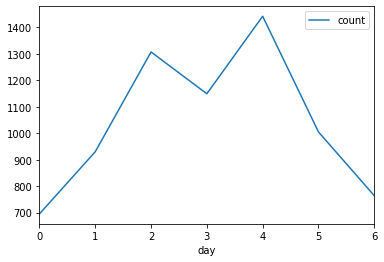

In [49]:
weekday_dist = pd.DataFrame(pred_msr_features.weekday.value_counts()).reset_index()
weekday_dist.columns = ['day', 'count']

weekday_dist = weekday_dist.sort_values(by='day')

weekday_dist.plot(x='day', y='count')


## Save features to file

In [42]:
pred_msr_features.to_csv('2019-09-27-basel-measures-prediction-cleaned-FEAT.csv', index=None)